# Challenge: Predicting the probability of flight delays at the airport of Santiago de Chile (SCL)

The problem consists in predicting the probability of delay of the flights that land or take off from the airport of Santiago de Chile (SCL). For that you will have a dataset using public and real data where each row corresponds to a flight that landed or took off from SCL during 2017. The following information is available for each flight:

- Fecha-I: Scheduled date and time of the flight.
- Vlo-I: Scheduled flight number.
- Ori-I: Programmed origin city code.
- Des-I: Programmed destination city code.
- Emp-I: Scheduled flight airline code.
- Fecha-O: Date and time of flight operation.
- Vlo-O: Flight operation number of the flight.
- Ori-O: Operation origin city code
- Des-O: Operation destination city code.
- Emp-O: Airline code of the operated flight.
- DIA: Day of the month of flight operation.
- MES: Number of the month of operation of the flight.
- AÑO: Year of flight operation.
- DIANOM: Day of the week of flight operation.
- TIPOVUELO: Type of flight, I =International, N =National.
- OPERA: Name of the airline that operates.
- SIGLAORI: Name city of origin.
- SIGLADES: Destination city name.

## 1. Task 1

How is the data distributed? Did you find any noteworthy insight to share? What can you conclude about this?

In [1]:
# Import libraries that will be used in the notebook

import numpy as np
import pandas as pd
from datetime import datetime, date, time, timedelta

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()


from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Display HTML representation in a Jupyter context
from sklearn import set_config
set_config(display='diagram')

In [2]:
import warnings
warnings.filterwarnings('ignore')

### 1.1 Read the data into a pandas DataFrame

In [3]:
flights = pd.read_csv('data/dataset_SCL.csv', 
                      header=0, 
                      dtype={'Vlo-I': str, 'Vlo-O': str},  # to handle mixed data types
                      parse_dates=['Fecha-I', 'Fecha-O'],  # read as datetime
                      infer_datetime_format=True)
flights.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


### 1.2 Main information about the `flights` DataFrame

In [4]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Fecha-I    68206 non-null  datetime64[ns]
 1   Vlo-I      68206 non-null  object        
 2   Ori-I      68206 non-null  object        
 3   Des-I      68206 non-null  object        
 4   Emp-I      68206 non-null  object        
 5   Fecha-O    68206 non-null  datetime64[ns]
 6   Vlo-O      68205 non-null  object        
 7   Ori-O      68206 non-null  object        
 8   Des-O      68206 non-null  object        
 9   Emp-O      68206 non-null  object        
 10  DIA        68206 non-null  int64         
 11  MES        68206 non-null  int64         
 12  AÑO        68206 non-null  int64         
 13  DIANOM     68206 non-null  object        
 14  TIPOVUELO  68206 non-null  object        
 15  OPERA      68206 non-null  object        
 16  SIGLAORI   68206 non-null  object       

There are 68,206 rows and 18 columns. 

17 Columns do not have missing values. 

In the `Vlo-O` column (operation flight number), one value is missing. This row still can be used for analysis and modelling because only the scheduled information can be used for prediction, and the operation details are unknown at that point.

In [5]:
# Check the DataFrame for duplicate rows

flights.duplicated().value_counts()

False    68206
dtype: int64

There are no duplicate rows in the `flights' DataFrame.

### 1.3 Analysis of the DataFrame columns

#### 1.3.1 `Fecha-I` (scheduled date and time of the flight) and `Fecha-O` (date and time of flight operation)

In [6]:
# Summary statistics for scheduled datetimes

flights['Fecha-I'].describe(datetime_is_numeric=False)

count                   68206
unique                  53252
top       2017-07-28 13:30:00
freq                        6
first     2017-01-01 00:15:00
last      2017-12-31 23:55:00
Name: Fecha-I, dtype: object

In [7]:
# Summary statistics for operation datetimes

flights['Fecha-O'].describe(datetime_is_numeric=False)

count                   68206
unique                  62774
top       2017-11-05 14:51:00
freq                        5
first     2017-01-01 00:04:00
last      2018-01-01 00:12:00
Name: Fecha-O, dtype: object

Scheduled dates and times are for 2017 year only (the latest record is 2017-12-31 23:55:00).

The latest record for the operation dates and times is 2018-01-01 00:12:00 (because of flight delay).

In [8]:
# Percentage of flights when operation time is later than scheduled

len(flights['Fecha-O'] > flights['Fecha-I']) / len(flights) * 100

100.0

For all the records the operation time is later than the scheduled time. So, the difference ('Fecha-O' - 'Fecha-I') will be a positive number for all rows.

#### 1.3.2 `Vlo-I` and `Vlo-O` (scheduled and operation flight numbers)

In [9]:
# Percentage of flights where the scheduled and operation
# flight number is the same

len(flights[flights['Vlo-I'] == flights['Vlo-O']]) / len(flights) * 100

93.37448318329766

In [10]:
flights['Vlo-I'].value_counts()

174     686
11      645
116     608
150     557
704     556
       ... 
1121      1
1116      1
1065      1
1054      1
1234      1
Name: Vlo-I, Length: 584, dtype: int64

In [11]:
flights['Vlo-O'].value_counts()

174     649
11      646
116     608
150     517
704     514
       ... 
2726      1
9860      1
9858      1
1297      1
1134      1
Name: Vlo-O, Length: 861, dtype: int64

About 93% of flights had the same scheduled and operation flight number.

There are 584 unique scheduled flight numbers and 861 unique operation flight numbers. For some flight numbers, there are many records, and for some - just 1 row. Flight numbers have too many categories and probably not very suitable as a variable for prediction.

#### 1.3.3 `Ori-I` and `Ori-O` (programmed and operation origin city codes)

In [12]:
flights['Ori-I'].value_counts()

SCEL    68206
Name: Ori-I, dtype: int64

In [13]:
flights['Ori-O'].value_counts()

SCEL    68206
Name: Ori-O, dtype: int64

All values in these columns - 'SCEL'. It means the departure airport for all flights in the dataset is Santiago de Chile Airport (IATA: SCL, ICAO: SCEL). So the prediction task means predicting the probability of departure delays for the flights from SCL.

#### 1.3.4 `Des-I` and `Des-O` (programmed and operation destination city codes)

In [14]:
# Number of records per programmed destination - summary

flights['Des-I'].value_counts().describe()

count      64.000000
mean     1065.718750
std      1496.220237
min         1.000000
25%        50.000000
50%       346.000000
75%      1609.250000
max      5787.000000
Name: Des-I, dtype: float64

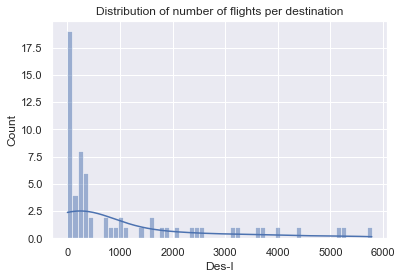

In [15]:
g = sns.histplot(flights['Des-I'].value_counts(), bins=60, kde=True)
g.set_title('Distribution of number of flights per destination');

In [16]:
# 10 Destination airports with largest number of flights

flights['Des-I'].value_counts()[:10]

SCFA    5787
SPJC    5270
SCCF    5145
SCTE    4357
SCIE    3995
SCDA    3747
SBGR    3570
SAEZ    3240
SABE    3094
SCQP    2583
Name: Des-I, dtype: int64

In [17]:
# Percentage of flights where the scheduled and operation
# destination airport is the same

len(flights[flights['Des-I'] == flights['Des-O']]) / len(flights) * 100

99.95894789314723

There 64 airports in the `Des-I` column. The number of records per destination varies from 1 to 5787. Half of the destinations have <= 346 records. 

Airports with the largest numbers of records are located in Chile, Peru, Brazil and Argentina. 

For almost all flights the programmed and operation destination airport is the same.

#### 1.3.5 `Emp-I` and `Emp-O` (scheduled and operation airline codes)

In [18]:
# Number of records per scheduled airline - summary

flights['Emp-I'].value_counts().describe()

count       30.000000
mean      2273.533333
std       7163.120100
min          1.000000
25%        123.750000
50%        343.000000
75%       1022.750000
max      37611.000000
Name: Emp-I, dtype: float64

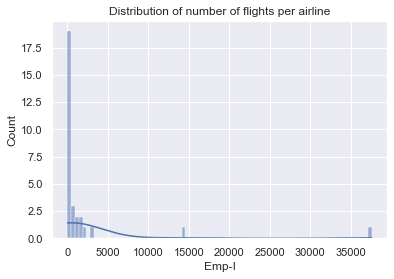

In [19]:
g = sns.histplot(flights['Emp-I'].value_counts(), bins=80, kde=True)
g.set_title('Distribution of number of flights per airline');

In [20]:
# Top 5 airlines with largest number of records

flights['Emp-I'].value_counts()[:5]

# LAN - Grupo LATAM:
# LATAM Airlines Chile (formerly LAN Airlines and LAN-Chile) is an airline based in Santiago, Chile, 
# one of the founders of LATAM Airlines Group

# SKU - Sky Airline

# TAM - Grupo LATAM: 
# (LATAM Airlines Brasil, formerly TAM Linhas Aéreas, is the Brazilian brand of LATAM Airlines Group)

# ARG - Aerolineas Argentinas

# CMP - Copa Air

LAN    37611
SKU    14298
TAM     3049
ARG     1949
CMP     1850
Name: Emp-I, dtype: int64

In [21]:
# Percentage of all records - top 5 airlines

flights['Emp-I'].value_counts()[:5] / len(flights) * 100

LAN    55.143243
SKU    20.962965
TAM     4.470281
ARG     2.857520
CMP     2.712371
Name: Emp-I, dtype: float64

In [22]:
# Percentage of flights where the scheduled and operation
# airline is the same

len(flights[flights['Emp-I'] == flights['Emp-O']]) / len(flights) * 100

72.6285077559159

There 30 airlines in the `Emp-I` column. The number of records per airline varies from 1 to 37611. Half of the airlines has <= 343 records. For two airlines the number of records is much larger than for other airlines. Flights by LAN comprise 55% of all records; the next airline is SKU (21% of all records).

For about 73% of flights the scheduled and operation airline code was the same.

#### 1.3.6 `DIA`, `MES` and `AÑO` (day of the month, number of the month and year of flight operation) 

**Day of the month**

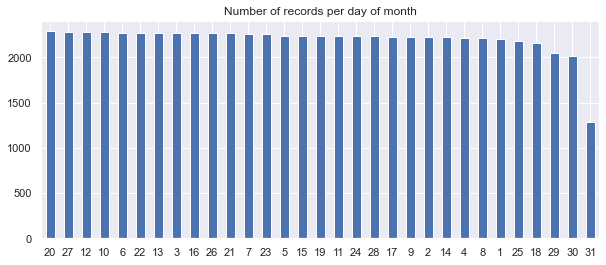

In [23]:
# Bar chart
# Sorted from higher number of records per day of month to lower

flights['DIA'].value_counts().plot(
    kind='bar', figsize=(10, 4), rot=0, 
    title='Number of records per day of month');

There are fewer records for the 31st day of month because it is present not in each month. For all other months, the number of records is very close.

**Month**

In [24]:
flights['MES'].value_counts()

12    6356
1     6108
11    6080
10    6032
7     5992
8     5744
9     5610
2     5561
3     5482
5     5240
4     5020
6     4981
Name: MES, dtype: int64

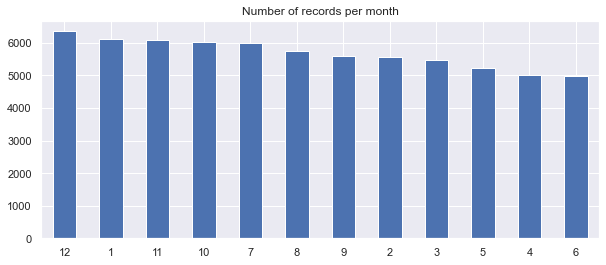

In [25]:
flights['MES'].value_counts().plot(
    kind='bar', figsize=(10, 4), rot=0, 
    title='Number of records per month');

All months are represented well. There are less flights in April, May, June than in other months.

**Year**

In [26]:
# Number of records per year

flights['AÑO'].value_counts()

2017    68204
2018        2
Name: AÑO, dtype: int64

In [27]:
# Flights with operation date in 2018

flights[flights['AÑO'] == 2018]

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
66918,2017-12-31 23:55:00,602,SCEL,KLAX,LAN,2018-01-01 00:02:00,602.0,SCEL,KLAX,LAN,1,1,2018,Lunes,I,Grupo LATAM,Santiago,Los Angeles
66947,2017-12-31 23:40:00,622,SCEL,MMMX,LAN,2018-01-01 00:12:00,622.0,SCEL,MMMX,LAN,1,1,2018,Lunes,I,Grupo LATAM,Santiago,Ciudad de Mexico


Almost all records are for 2017. Only 2 flights have departure date in 2018 (2018-01-01), they were scheduled for 2017-12-31.

**Day of week**

In [28]:
flights['DIANOM'].value_counts()

Viernes      10292
Jueves       10251
Lunes        10131
Domingo       9796
Miercoles     9722
Martes        9662
Sabado        8352
Name: DIANOM, dtype: int64

For days of the week the data is distributed quite evenly. On Saturdays, there were little fewer flights than on other days.

The columns `DIA`, `MES`, `AÑO` and `DIANOM` have the operation information, not the scheduled details. There are 2 flights that were scheduled for 2017-12-31 and actually departed on 2018-01-01, so the value in `AÑO` is 2018.

In order to use the month and day of the week as variables for delay prediction, the new corresponding columns should be created from the scheduled datetime.

#### 1.3.7 `TIPOVUELO`: Type of flight 

I = International, N = National

In [29]:
# Number of flights per type of flight

flights['TIPOVUELO'].value_counts()

N    36966
I    31240
Name: TIPOVUELO, dtype: int64

In [30]:
# Percentage

flights['TIPOVUELO'].value_counts() / len(flights) * 100

N    54.197578
I    45.802422
Name: TIPOVUELO, dtype: float64

Dataset includes more national flights than international flights but the difference is not large.

**Note:**

I did not explore the following columns as they have info closely related to other columns about the airline, origin and destination:
- OPERA : Name of the airline that operates.
- SIGLAORI: Name city of origin.
- SIGLADES: Destination city name.

## 2. Task 2

Generate the following additional columns. Please export them to a CSV file named synthetic_features.csv:
- `high_season`: 1 if Date-I is between Dec-15 and Mar-3, or Jul-15 and Jul-31, or Sep-11 and Sep-30, 0 otherwise.
- `min_diff`: difference in minutes between Date-O and Date-I.
- `delay_15`: 1 if min_diff > 15, 0 if not.
- `period_day`: morning (between 5:00 and 11:59), afternoon (between 12:00 and 18:59) and night (between 19:00 and 4:59), based on Date-I.

In [31]:
# Import functions needed for feature generation 
# from the preprocessing module

from modules.preprocessing import is_high_season, get_period_day

In [32]:
# Create a copy of the flights DataFrame

flights2 = flights.copy()

In [33]:
# Create new columns according to the task 2

flights2['high_season'] = flights2['Fecha-I'].map(is_high_season)
flights2['min_diff'] = (flights2['Fecha-O'] - flights2['Fecha-I']).dt.seconds / 60
flights2['delay_15'] = flights2['min_diff'].map(lambda x: 1 if x > 15 else 0)
flights2['period_day'] = flights2['Fecha-I'].map(get_period_day)

In [34]:
flights2.head(3)

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,high_season,min_diff,delay_15,period_day
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,...,2017,Domingo,I,American Airlines,Santiago,Miami,1,3.0,0,night
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,...,2017,Lunes,I,American Airlines,Santiago,Miami,1,9.0,0,night
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,...,2017,Martes,I,American Airlines,Santiago,Miami,1,9.0,0,night


In [35]:
flights2.tail(3)

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,high_season,min_diff,delay_15,period_day
68203,2017-12-27 14:55:00,400,SCEL,SPJC,JAT,2017-12-27 15:35:00,400.0,SCEL,SPJC,JAT,...,2017,Miercoles,I,JetSmart SPA,Santiago,Lima,1,40.0,1,afternoon
68204,2017-12-29 14:55:00,400,SCEL,SPJC,JAT,2017-12-29 15:08:00,400.0,SCEL,SPJC,JAT,...,2017,Viernes,I,JetSmart SPA,Santiago,Lima,1,13.0,0,afternoon
68205,2017-12-31 14:55:00,400,SCEL,SPJC,JAT,2017-12-31 15:04:00,400.0,SCEL,SPJC,JAT,...,2017,Domingo,I,JetSmart SPA,Santiago,Lima,1,9.0,0,afternoon


In [36]:
# Save 4 new columns to a separate csv file

flights2.to_csv('data/synthetic_features.csv', 
                columns=['high_season', 'min_diff', 'delay_15', 'period_day'], 
                header=True, index=False)

## 3. Task 3

What is the behavior of the delay rate across destination, airline, month of the year, day of the week, season, type of flight? What variables would you expect to have the most influence in predicting delays?

### 3.1 Summary statistics for `min_diff` (flight delay in minutes)

In [37]:
flights2['min_diff'].describe()

count    68206.000000
mean       387.235947
std        626.191717
min          0.000000
25%          4.000000
50%         12.000000
75%       1430.000000
max       1439.000000
Name: min_diff, dtype: float64

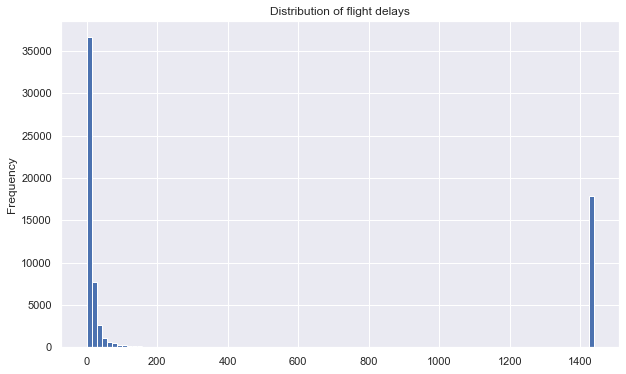

In [38]:
# Histogram

flights2['min_diff'].plot(kind='hist', bins=100, 
                          title='Distribution of flight delays', 
                          figsize=(10, 6));

### 3.2 Target variable `delay_15`

Check the ratio of classes (0: delay < 15 min, 1: delay >= 15 min)

In [39]:
# Percentage of classes 0 and 1

flights2['delay_15'].value_counts() / len(flights2) * 100

0    55.247339
1    44.752661
Name: delay_15, dtype: float64

Both classes are represented well. This ratio can be kept during the train-test split of data.

### 3.3 Delays by destination

In [40]:
# Group by destination and calculate the number of flights 
# and the mean delay in minutes, then sort my mean delay

delays_by_dest = flights2[['Des-I', 'min_diff']].groupby('Des-I').agg(['count', 'mean'])
delays_by_dest.sort_values(('min_diff', 'mean'), ascending=False)

min_diff             
         count         mean
Des-I                      
SARI         1  1438.000000
KIAH       335  1077.068657
KDFW       357  1035.557423
SBCT         3   957.333333
KATL       358   872.963687
...        ...          ...
SAWH         6    24.500000
SEQM         1    24.000000
SAZS         2    18.500000
SBFI         1     5.000000
SPSO         1     2.000000

[64 rows x 2 columns]

In [41]:
# Statistics for average delays by destination 

delays_by_dest[('min_diff', 'mean')].describe()

count      64.000000
mean      357.778576
std       277.174010
min         2.000000
25%       194.419929
50%       326.691342
75%       427.880602
max      1438.000000
Name: (min_diff, mean), dtype: float64

The average delay in minutes varies in a wide range for different destination airports. However, for some airports there are not many data points.

### 3.4 Delays by airline

In [42]:
# Group by airline and calculate the number of flights 
# and the mean delay in minutes, then sort my mean delay

delays_by_airline = flights2[['Emp-I', 'min_diff']].groupby('Emp-I').agg(['count', 'mean'])

delays_by_airline_sorted = delays_by_airline.sort_values(('min_diff', 'mean'), 
                                                         ascending=False)
delays_by_airline_sorted

min_diff             
         count         mean
Emp-I                      
UAL        335  1077.068657
AMX        351  1027.247863
AAL        757   930.475561
KLM        251   873.342629
DAL        358   872.963687
CMP       1850   811.284324
AFR        358   773.689944
LRC         92   630.967391
ONE        279   615.372760
GLO        806   572.904467
ARG       1949   535.320164
AVA       1152   534.881944
AZA        259   533.478764
IBE        362   509.469613
JAT       1095   490.072146
SKU      14298   489.426423
AUT         74   473.635135
BAW        205   422.000000
LAW       1574   308.157560
LAN      37611   287.851373
ACA        565   285.423009
JMR        100   255.240000
TAM       3049   251.368973
LAP        216   239.092593
PUE         49   178.653061
QFU        195   108.066667
DSM          2    73.000000
LXP          9    52.555556
LPE          4    26.000000
LNE          1    24.000000

For some airlines with lowest average delays in minutes, only a few records are available. The average delay in minutes varies in a wide range for different airlines.

Statistics and visualization:

In [43]:
delays_by_airline[('min_diff', 'mean')].describe()

count      30.000000
mean      475.433676
std       304.180668
min        24.000000
25%       252.336730
50%       489.749285
75%       627.068733
max      1077.068657
Name: (min_diff, mean), dtype: float64

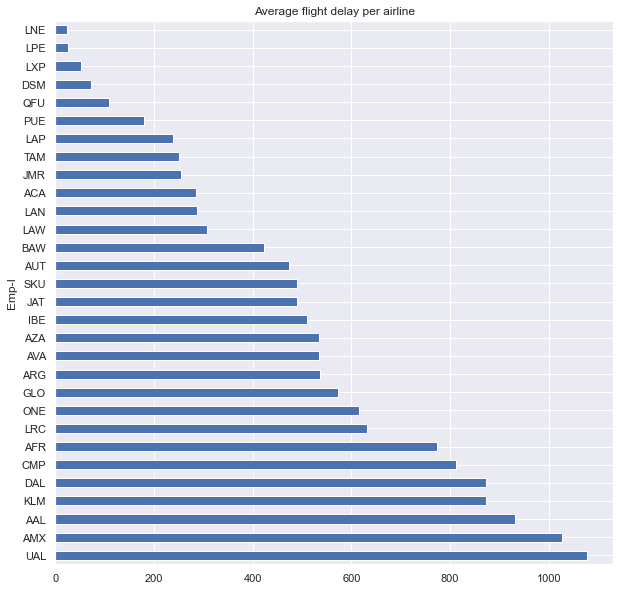

In [44]:
delays_by_airline_sorted[('min_diff', 'mean')].plot(
    kind='barh', figsize=(10, 10), 
    title='Average flight delay per airline');

### 3.5 Delays by month

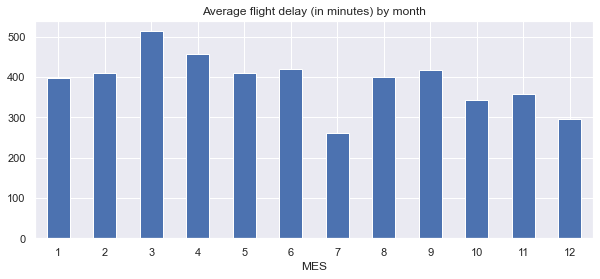

In [45]:
delays_by_month = flights2[['MES', 'min_diff']].groupby('MES').agg(['count', 'mean'])

delays_by_month[('min_diff', 'mean')].plot(
    kind='bar', figsize=(10, 4), rot=0, 
    title='Average flight delay (in minutes) by month');

Some differences are observed between average delays for different months.

### 3.6 Delays by day of the week

In [46]:
delays_by_weekday = flights2[['DIANOM', 'min_diff']].groupby('DIANOM').agg(['count', 'mean'])
delays_by_weekday

min_diff            
             count        mean
DIANOM                        
Domingo       9796  421.732340
Jueves       10251  367.168179
Lunes        10131  375.133156
Martes        9662  410.874974
Miercoles     9722  394.683604
Sabado        8352  424.004670
Viernes      10292  327.238146

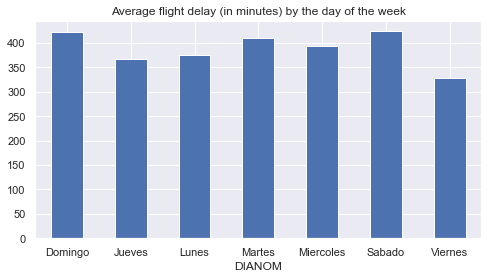

In [47]:
delays_by_weekday[('min_diff', 'mean')].plot(
    kind='bar', figsize=(8, 4), rot=0, 
    title='Average flight delay (in minutes) by the day of the week');

There is some difference between the days of the week. For Friday, the average delay is lower than for other days.

### 3.7 Delays by season

In [48]:
# Group by season and calculate the number of flights 
# and the mean delay in minutes

delays_by_season = flights2[['high_season', 'min_diff']].groupby('high_season').agg(['count', 'mean'])
delays_by_season

min_diff            
               count        mean
high_season                     
0              45444  394.396884
1              22762  372.939241

In [49]:
# Not a high season

flights2.loc[flights2['high_season'] == 0, 'min_diff'].describe()

count    45444.000000
mean       394.396884
std        630.216250
min          0.000000
25%          4.000000
50%         12.000000
75%       1431.000000
max       1439.000000
Name: min_diff, dtype: float64

In [50]:
# High season

flights2.loc[flights2['high_season'] == 1, 'min_diff'].describe()

count    22762.000000
mean       372.939241
std        617.843949
min          0.000000
25%          4.000000
50%         13.000000
75%       1427.000000
max       1439.000000
Name: min_diff, dtype: float64

There are twice more records for the regular season than for high season. The summary statistics for average delays for both seasons is quite similar.

### 3.8 Delays by type of flight

In [51]:
# Group by flight type and calculate the number of flights 
# and the mean delay in minutes

delays_by_flight_type = flights2[['TIPOVUELO', 'min_diff']].groupby(
    'TIPOVUELO').agg(['count', 'mean'])
delays_by_flight_type

min_diff            
             count        mean
TIPOVUELO                     
I            31240  394.562068
N            36966  381.044636

Average delay values for both flight types are very close.

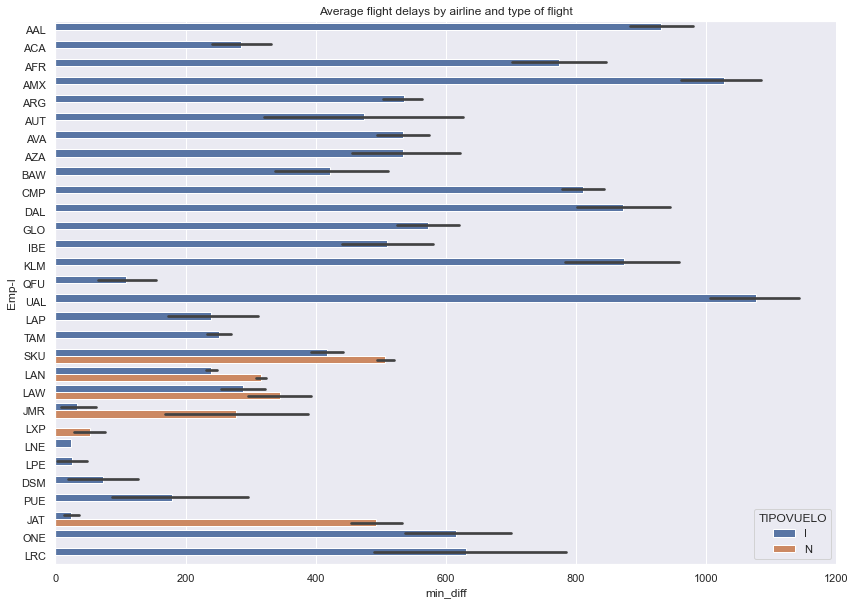

In [52]:
# The bars are the average values of delay in minutes
# Black lines represent the 95% confidence interval

plt.figure(figsize=(14, 10))
g = sns.barplot(data=flights2, x='min_diff', y='Emp-I', 
                hue='TIPOVUELO', orient='h')
g.set_title("Average flight delays by airline and type of flight");

In [53]:
# Percentage of delays over 15 min by flight type

flights2[['TIPOVUELO', 'delay_15']].groupby('TIPOVUELO').mean()

,delay_15
TIPOVUELO,
I,0.492222
N,0.409755


Most airlines operate international flights. For those airlines that operate both types: the average delay is higher for national flights of the airline than for its international flights.

### 3.9 Delays by period of day

In [54]:
# Group by the period of the day and calculate the number of flights 
# and the mean delay in minutes

delays_by_period_day = flights2[['period_day', 'min_diff']].groupby(
    'period_day').agg(['count', 'mean'])
delays_by_period_day

min_diff           
              count       mean
period_day                    
afternoon     25506  354.37254
morning       25352  391.91764
night         17348  428.71184

There is some difference between average delays in minutes for morning, afternoon and night. 

**Conclusions:**

It seems that the magnitude of delay depends on the destination airport and the airline. However, these columns have many categories (64 and 30 respectively), and for some airports and airlines there is a very small number of records. 

Also, I would expect that the scheduled month, period of day and day of week of the flight would have influence in predicting delays. Probably the season and flight type could help for a better prediction too.

It is good to try training a model with most of these variables and see the feature importances.

## 4. Task 4

Train one or several models (using the algorithm(s) of your choice) to estimate the likelihood of a flight delay.
Feel free to generate additional variables and/or supplement with external variables.

### 4.1 Prepare a final DataFrame with features and a target

In [55]:
# Create a copy of flights2 with selected columns

selected_columns = ['Fecha-I', 'Emp-I', 'TIPOVUELO', 
                    'high_season', 'period_day', 'delay_15', 
                    'min_diff']

flights3 = flights2[selected_columns].copy()
flights3.head(3)

,Fecha-I,Emp-I,TIPOVUELO,high_season,period_day,delay_15,min_diff
0,2017-01-01 23:30:00,AAL,I,1,night,0,3.0
1,2017-01-02 23:30:00,AAL,I,1,night,0,9.0
2,2017-01-03 23:30:00,AAL,I,1,night,0,9.0


In [56]:
# Create new columns from the scheduled date: 

# Scheduled month of the flight
flights3['month'] = flights3['Fecha-I'].dt.month

# Scheduled day of week (Monday is 0)
flights3['weekday'] = flights3['Fecha-I'].dt.weekday

flights3.head(3)

,Fecha-I,Emp-I,TIPOVUELO,high_season,period_day,delay_15,min_diff,month,weekday
0,2017-01-01 23:30:00,AAL,I,1,night,0,3.0,1,6
1,2017-01-02 23:30:00,AAL,I,1,night,0,9.0,1,0
2,2017-01-03 23:30:00,AAL,I,1,night,0,9.0,1,1


Group the airlines into 3 categories and create a column with airline rank based on the average delay value:
- 'low' - average delay < 300 min,
- 'middle' - average delay between 300 min and 600 min,
- 'high' - average delay > 600 min

In [57]:
avg_delays_by_airline = flights3[['Emp-I', 'min_diff']].groupby('Emp-I').mean()
avg_delays_by_airline.head()

,min_diff
Emp-I,
AAL,930.475561
ACA,285.423009
AFR,773.689944
AMX,1027.247863
ARG,535.320164


In [58]:
def rank_airline(delay_min):
    """Rank the airline based on its average delay in minutes."""
    if delay_min < 300:
        return 'low'
    elif delay_min > 600:
        return 'high'
    else:
        return 'middle'

In [59]:
avg_delays_by_airline['airline_rank'] = avg_delays_by_airline['min_diff'].map(rank_airline)
avg_delays_by_airline.head()

,min_diff,airline_rank
Emp-I,,
AAL,930.475561,high
ACA,285.423009,low
AFR,773.689944,high
AMX,1027.247863,high
ARG,535.320164,middle


In [60]:
# Add column with airline rank

flights4 = pd.merge(flights3, avg_delays_by_airline['airline_rank'], 
                    on='Emp-I', 
                    how='left')

flights4.drop(['Fecha-I', 'Emp-I', 'min_diff'], axis=1, inplace=True)
flights4.head(3)

,TIPOVUELO,high_season,period_day,delay_15,month,weekday,airline_rank
0,I,1,night,0,1,6,high
1,I,1,night,0,1,0,high
2,I,1,night,0,1,1,high


In [61]:
flights4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68206 entries, 0 to 68205
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   TIPOVUELO     68206 non-null  object
 1   high_season   68206 non-null  int64 
 2   period_day    68206 non-null  object
 3   delay_15      68206 non-null  int64 
 4   month         68206 non-null  int64 
 5   weekday       68206 non-null  int64 
 6   airline_rank  68206 non-null  object
dtypes: int64(4), object(3)
memory usage: 4.2+ MB


### 4.2 Split the data into the training and test sets

In [62]:
# Split features and target
X = flights4.drop(columns='delay_15')
y = flights4['delay_15'].copy()

# Split the data and keep the proportions of delay_15 classes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)

In [63]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(54564, 6)
(54564,)
(13642, 6)
(13642,)


### 4.3 Train different models

Try a few pipelines which include one-hot encoding of categorical features and then a classification model. The second pipeline includes the dimensionality reduction/feature selection step in-between.

In [64]:
# All final features are categorical
# Create a list of categorical features

cat_features = list(X.columns)
cat_features

['TIPOVUELO', 'high_season', 'period_day', 'month', 'weekday', 'airline_rank']

#### Pipeline 1: Preprocessing (one-hot encoding), Logistic Regression

In [65]:
categorical_transform = Pipeline([('one_hot_encode', OneHotEncoder(sparse=False))])

preprocessing_flights = ColumnTransformer([('categorical', categorical_transform, cat_features)])

pipeline_1 = Pipeline([('preprocessing', preprocessing_flights), 
                       ('model', LogisticRegression())])

pipeline_1.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('one_hot_encode',
                                                                   OneHotEncoder(sparse=False))]),
                                                  ['TIPOVUELO', 'high_season',
                                                   'period_day', 'month',
                                                   'weekday',
                                                   'airline_rank'])])),
                ('model', LogisticRegression())])

#### Pipeline 2: Preprocessing (one-hot encoding), feature union (PCA and SelectKBest), Logistic Regression

In [66]:
categorical_transform = Pipeline([('one_hot_encode', OneHotEncoder(sparse=False))])

preprocessing_flights = ColumnTransformer([('categorical', categorical_transform, cat_features)])

feature_union = FeatureUnion([('pca', PCA(n_components=3)), 
                              ('select_best', SelectKBest(k=5))])

pipeline_2 = Pipeline([('preprocessing', preprocessing_flights), 
                       ('features', feature_union),
                       ('model', LogisticRegression())])

pipeline_2.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('one_hot_encode',
                                                                   OneHotEncoder(sparse=False))]),
                                                  ['TIPOVUELO', 'high_season',
                                                   'period_day', 'month',
                                                   'weekday',
                                                   'airline_rank'])])),
                ('features',
                 FeatureUnion(transformer_list=[('pca', PCA(n_components=3)),
                                                ('select_best',
                                                 SelectKBest(k=5))])),
                ('model', LogisticRegression())])

### Pipeline 3 (Grid Search): Preprocessing (one-hot encoding), Random Forest Classifier

In [67]:
categorical_transform = Pipeline([('one_hot_encode', OneHotEncoder(sparse=False))])

preprocessing_flights = ColumnTransformer([('categorical', categorical_transform, cat_features)])

pipeline_3 = Pipeline([('preprocessing', preprocessing_flights), 
                       ('rf_classifier', RandomForestClassifier())])

# Set up the parameter grid
param_grid = {"rf_classifier__n_estimators":[2, 5, 10], 
              "rf_classifier__max_depth":[3, 5]}

# Create a Grid Search object
grid_search = GridSearchCV(pipeline_3, param_grid, n_jobs = -1, verbose=10, refit=True)    

# Fit the model and tune parameters
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('categorical',
                                                                         Pipeline(steps=[('one_hot_encode',
                                                                                          OneHotEncoder(sparse=False))]),
                                                                         ['TIPOVUELO',
                                                                          'high_season',
                                                                          'period_day',
                                                                          'month',
                                                                          'weekday',
                                                                          'airline_rank'])])),
                                       ('rf_classifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rf_classifier__max_depth': [3, 5],
                         'rf_classifier__n_estimators': [2, 5, 10]},
             verbose=10)

In [68]:
print(grid_search.best_params_)

{'rf_classifier__max_depth': 5, 'rf_classifier__n_estimators': 2}


## 5. Task 5

Evaluate model performance in the predictive task across each model that you trained. Define and justify what metrics you used to assess model performance. Pick the best trained model and evaluate the following: What variables were the most influential in the prediction task? How could you improve the Performance?

### Model evaluation

To evaluate model performance I used the accuracy as the basic metric and calculated it for both training and test sets to assess overfitting. Also, I looked at the confusion matrix for the test set and checked whether the number of false negatives is decreasing. Other possible metrics are recall (I assume it is important to predict as many actual positives as possible and reduce false negatives) and ROC AUC score.

#### Pipeline 1: Preprocessing (one-hot encoding), Logistic Regression

In [69]:
acc_train_1 = pipeline_1.score(X_train, y_train)
print(f'Training set accuracy: {acc_train_1}')

Training set accuracy: 0.5969686973095815


In [70]:
acc_test_1 = pipeline_1.score(X_test, y_test)
print(f'Test set accuracy: {acc_test_1}')

Test set accuracy: 0.6031373698871133


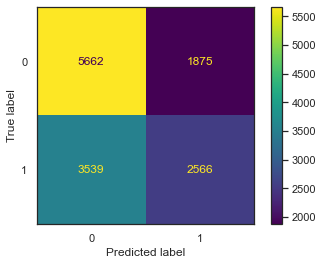

In [71]:
sns.set_style("white")

y_pred_1 = pipeline_1.predict(X_test)
cm_1 = confusion_matrix(y_test, y_pred_1, labels=pipeline_1.classes_)
disp_1 = ConfusionMatrixDisplay(confusion_matrix=cm_1, display_labels=pipeline_1.classes_)
disp_1.plot()
plt.show()

#### Pipeline 2: Preprocessing (one-hot encoding), feature union (PCA and SelectKBest), Logistic Regression

In [72]:
acc_train_2 = pipeline_2.score(X_train, y_train)
print(f'Training set accuracy: {acc_train_2}')

Training set accuracy: 0.5978667253133935


In [73]:
acc_test_2 = pipeline_2.score(X_test, y_test)
print(f'Test set accuracy: {acc_test_2}')

Test set accuracy: 0.6088550065972731


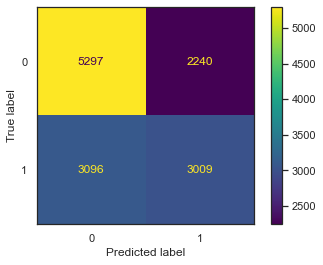

In [74]:
y_pred_2 = pipeline_2.predict(X_test)
cm_2 = confusion_matrix(y_test, y_pred_2, labels=pipeline_2.classes_)
disp_2 = ConfusionMatrixDisplay(confusion_matrix=cm_2, display_labels=pipeline_2.classes_)
disp_2.plot()
plt.show()

### Pipeline 3 (Grid Search): Preprocessing (one-hot encoding), Random Forest Classifier

In [75]:
acc_train_3 = grid_search.score(X_train, y_train)
print(f'Training set accuracy: {acc_train_3}')

Training set accuracy: 0.5934315666006891


In [76]:
acc_test_3 = grid_search.score(X_test, y_test)
print(f'Test set accuracy: {acc_test_3}')

Test set accuracy: 0.6009382788447442


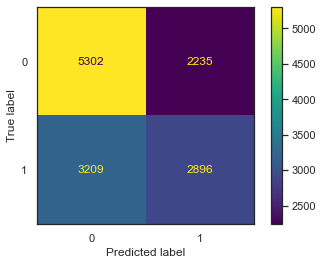

In [77]:
y_pred_3 = grid_search.predict(X_test)
cm_3 = confusion_matrix(y_test, y_pred_3, labels=grid_search.classes_)
disp_3 = ConfusionMatrixDisplay(confusion_matrix=cm_3, display_labels=grid_search.classes_)
disp_3.plot()
plt.show()

The models showed very similar performance. The pipeline 2 demonstrated the best test accuracy of 60.9% and it had the smallest number of false negatives. 

As one of the ways to find feature importances, a Random Forest model can be trained on one-hot encoded features. Unfortunately, the pipelines do not allow to extract feature importances.

To improve the performance, probably more feature engineering and selection can be done, other models can be trained and finetuned. For example, distance between origin and destination can be added as a feature. Also, adding more data could possibly help. 